In [11]:
from __future__ import print_function, division

%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import argparse
import sys
from PIL import Image, ImageFile
import cv2

ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
import torchsample
# custom datasets
from data_utils.miniplaces_dataset import MiniPlacesDataset
from techniques.generate_grounding import gen_grounding
from techniques.utils import pointing_game, jensenshannon, get_img_mask

In [12]:
def convert_img(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    displ_img = std * img + mean
    displ_img = np.clip(displ_img, 0, 1)
    displ_img /= np.max(displ_img)
    displ_img = np.uint8(displ_img * 255)
    return displ_img

In [22]:
OBJ_NAMES = [
    'backpack', 'bird', 'dog', 'elephant', 'kite', 'pizza', 'stop_sign',
    'toilet', 'truck', 'zebra'
]

data_dir = '/work/lisabdunlap/bam/data/obj/'

torch.cuda.set_device(5)

In [14]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomSizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #torchsample.transforms.RandomRotate(30),
        torchsample.transforms.RandomGamma(0.5, 1.5),
        torchsample.transforms.RandomSaturation(-0.8, 0.8),
        torchsample.transforms.RandomBrightness(-0.3, 0.3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/work/lisabdunlap/bam/data/obj/'

dsets = dict()
dsets['train'] = MiniPlacesDataset(
        photos_path=os.path.join(data_dir),
        labels_path=os.path.join(data_dir, 'train.txt'),
        transform=data_transforms['train'],
        train=True,
        location_paths=os.path.join(data_dir, 'loc_train.txt')
    )
dsets['val'] = MiniPlacesDataset(
        photos_path=os.path.join(data_dir),
        labels_path=os.path.join(data_dir, 'val2.txt'),
        transform=data_transforms['val'],
        train=False,
        location_paths=os.path.join(data_dir, 'loc_val.txt')
    )

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=1,
                                               shuffle=False, num_workers=1)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_sizes

# images found at path '/work/lisabdunlap/bam/data/obj/train.txt': 90000
# images found at path '/work/lisabdunlap/bam/data/obj/val2.txt': 10000


{'train': 90000, 'val': 10000}

label:  0
path:  train/backpack/backpack-bamboo_forest-0001.jpg


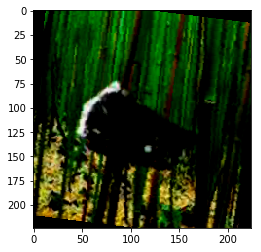

In [15]:
img, label, path, loc = dsets['train'][1]
print('label: ', label)
print('path: ', path)
sample_img = convert_img(img)
plt.imshow(sample_img)

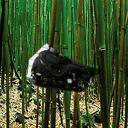

In [16]:
Image.open('/work/lisabdunlap/bam/data/obj/'+path)

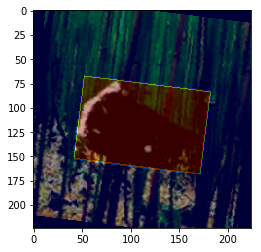

In [17]:
sample_mask = loc.numpy()[0]
sample_img = convert_img(img)
sample_mask = cv2.cvtColor(cv2.applyColorMap(np.uint8((sample_mask / np.max(sample_mask)) * 255.0), cv2.COLORMAP_JET),
                           cv2.COLOR_BGR2RGB)
alpha = .4
cam = sample_mask*alpha + np.float32(sample_img)*(1-alpha)
cam /= np.max(cam)
plt.imshow(cam)

In [26]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [ ]:
expl_masks = torch.tensor(expl_masks)
                print()
                print('mask loss: ', mask_loss)
                mask_loss = nn.MSELoss()
                print('mask loss: ', mask_loss(mask_results, mask_target))

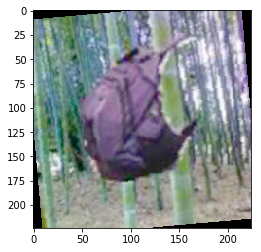

In [223]:
sample_img = convert_img(inputs[0])
plt.imshow(sample_img)

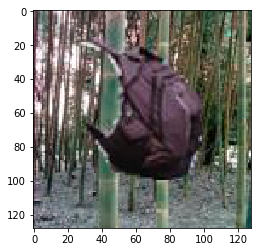

In [224]:
path_img = cv2.imread('/work/lisabdunlap/bam/data/obj/'+paths[0])
plt.imshow(path_img)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


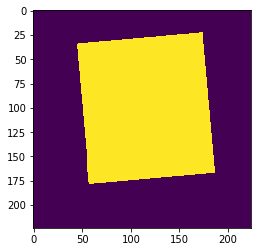

In [226]:
true_loc = locations[0].cpu().numpy()[0]
print(true_loc)
plt.imshow(true_loc)

In [48]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()

In [49]:
logits = m(input)
output = loss(torch.sigmoid(logits), target)

In [50]:
output

tensor(0.6743, grad_fn=<BinaryCrossEntropyBackward>)

In [53]:
print(target)
print(torch.sigmoid(logits))

tensor([1., 0., 1.])
tensor([0.6474, 0.6612, 0.6030], grad_fn=<SigmoidBackward>)
